<a href="https://colab.research.google.com/github/mrdobson/SENSIP_2021_REU/blob/main/jpnb/mnist_qnn_2class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install pylatexenc

  Using cached https://files.pythonhosted.org/packages/79/19/44f002f6633c64b4ab88d274dd036857624e4ba8b701cd90a408103a3791/qiskit-0.27.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/c2/d2/6ff15c370b5465b32529b528bf3f4ce1e01f74498be16203aa1c04b67022/qiskit_aer-0.8.2-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/83/2f/6f3b53b633cc477dbe601728c8c3fc8674441cb9554d14517254a52d0c8a/qiskit_ibmq_provider-0.14.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/54/be/a13c828e457e09d979667a61bddbd8c7246aafa94e2501b6a9154429cbea/qiskit_ignis-0.6.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/81/00/1f71631bbc3fd24537d7ec1c52adfcf4fa0851c13fefc05d6babcb11a1f8/qiskit_aqua-0.9.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8d/43/7339dbabbc2793718d59703aace4166f53c29ee1c202f6ff5bf8a26c4d91/pybind11-2.6.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.

In [ ]:
# not all of these are critical, but to be safe just including everything for now
import numpy as np
import matplotlib.pyplot as plt
import time

from torch import tensor
from torch import cat, no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, CrossEntropyLoss,
                      MaxPool2d, Flatten, Sequential, ReLU)
import torch.optim as optim
import torch.nn.functional as F

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, ADAM

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

# Mode Parameters

In [ ]:
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024)
qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'))

# modify these parameters to change which two characters we're going to
# compare against in the model
samp_val_1 = 1
samp_val_2 = 7

# MNIST Training Data Load

In [ ]:
# training set
n_samples = 210

# returns tuple with X_train.data and X_train.targets <-- what I don't have from iris
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# leave only labels samp_val_1 and samp_val_2
idx = np.append(np.where(X_train.targets == samp_val_1)[0][:n_samples],
                np.where(X_train.targets == samp_val_2)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# samp vals tunable above in the settings, this is to fit to our data loader
X_train.targets[X_train.targets==samp_val_1] = 0
X_train.targets[X_train.targets==samp_val_2] = 1
### DEBUG vnv that we remapped the correct samples 
#print("xtrain targets ", X_train.targets, "\n")

# perform training load
train_loader = DataLoader(X_train, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# MNIST Test Data Load

In [ ]:
n_samples = 90

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))
# selecting which samples to keep (first 100 0s and 1s)
idx = np.append(np.where(X_test.targets == samp_val_1)[0][:n_samples], 
                np.where(X_test.targets == samp_val_2)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# samp vals tunable above in the settings, to fit to data loader
X_test.targets[X_test.targets==samp_val_1] = 0
X_test.targets[X_test.targets==samp_val_2] = 1
### DEBUG    
#print("xtest targets ", X_train.targets, "\n")

# perform testing load
test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

# Define QNN

In [ ]:
num_inputs = 2

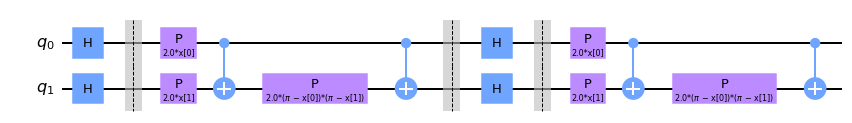

In [ ]:
# ZZ is 2nd order Pauli expansion circuit
fm = ZZFeatureMap(num_inputs, insert_barriers=True)
fm.draw(output='mpl')

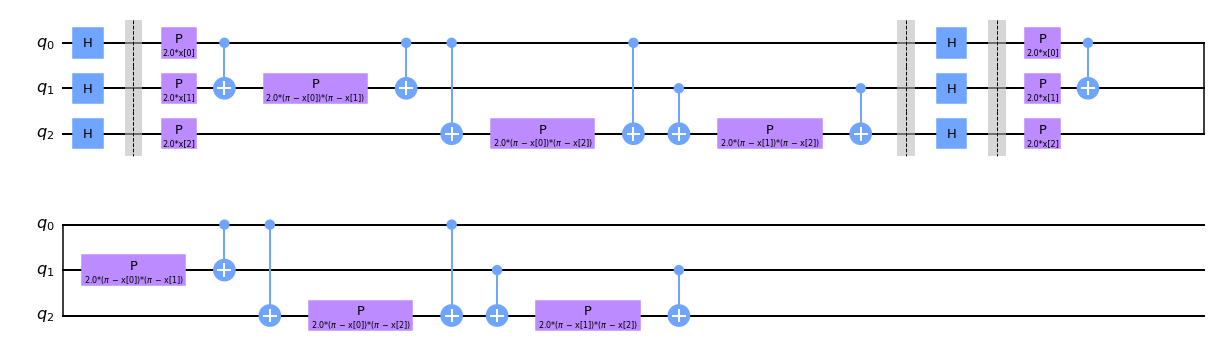

In [ ]:
fm3 = ZZFeatureMap(3, insert_barriers=True)
fm3.draw(output='mpl')

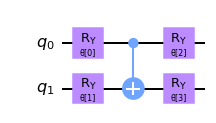

In [ ]:
# RealAmplitudes is used as an ansatz for ML, heuristic trial wave func
ansatz = RealAmplitudes(num_inputs, reps=1)
ansatz.draw(output='mpl')

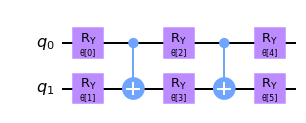

In [ ]:
ansatz2 = RealAmplitudes(num_inputs, reps=2)
ansatz2.draw(output='mpl')

In [ ]:
# define observable
observable = PauliSumOp.from_list([('Z'*num_inputs, 1)])
print(observable)

1.0 * ZZ


In [ ]:
# define two layer QNN
qnn_qasm = TwoLayerQNN(num_inputs, 
                  feature_map=fm, 
                  ansatz=ansatz, 
                  observable=observable,
                  quantum_instance=qi_qasm)

qnn_sv = TwoLayerQNN(num_inputs, 
                  feature_map=fm, 
                  ansatz=ansatz, 
                  observable=observable,
                  quantum_instance=qi_sv)

print(qnn_qasm.operator)
print(qnn_sv.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌────────────────────┐┌──────────────────────────────┐
  q_0: ┤0                   ├┤0                             ├
       │  nlocal(x[0],x[1]) ││  nlocal(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                   ├┤1                             ├
       └────────────────────┘└──────────────────────────────┘
  )
])
ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌────────────────────┐┌──────────────────────────────┐
  q_0: ┤0                   ├┤0                             ├
       │  nlocal(x[0],x[1]) ││  nlocal(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                   ├┤1                             ├
       └────────────────────┘└──────────────────────────────┘
  )
])


# QNN (QASM)

In [ ]:
class Net(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn_qasm)  
        self.fc3 = Linear(1, 1)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model = Net()

In [ ]:
# define model, optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start Training (QASM)

In [ ]:
epochs = 7    # set num epochs
loss_list = [] # store loss history
model.train()  # place model in training mode

# start training timer
start_train = time.time()

for epoch in range(epochs):
    print('Starting epoch {} for 2 qubits'.format(epoch))
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True) # init gradient
        output = model(data)             # forward pass
        ### DEBUG
        #print("target is: ", target)
        #print("output is: ", output)
        loss = loss_func(output, target) # calc loss
        loss.backward()                  # backward pass
        optimizer.step()                 # optimize weights
        total_loss.append(loss.item())   # store loss
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:0f}%]\tLoss: {:.4f}'.format(
           100. * (epoch + 1) / epochs, loss_list[-1]))
    
end_train = time.time()
print('Training runtime is: ', (end_train - start_train)/60, ' min')

Starting epoch 0 for 2 qubits


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training [14.285714%]	Loss: 0.6462
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.3970
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.2422
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.1600
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.1120
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0981
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0573
Training runtime is:  7.22142264842987  min


Qasm cost reduction


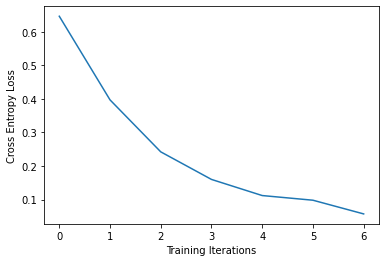

In [ ]:
# plot results of cost reduction
print("Qasm cost reduction")
plt.figure(3)
plt.plot(loss_list)
#plt.title('Cost Reduction for 2 qubits over {0} epochs'.format(epochs))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Perform Evaluations (QASM)

In [ ]:
# start eval time
start_eval = time.time()

model.eval() # set into eval mode
with no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
            
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    # batch_size goes where the 1 is here
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
           .format(sum(total_loss) / len(total_loss),
                correct / len(test_loader) / 1 * 100))
    
# end eval time
end_eval = time.time()
print('Evaluation time is: ', (end_eval - start_eval)/60, ' min')

Performance on test data:
	Loss: 0.0574
	Accuracy: 99.4%
Evaluation time is:  0.027951236565907797  min


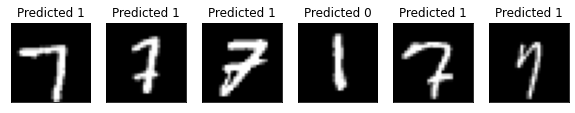

In [ ]:
# handful of examples for 2 qubit system
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        # remap class values to samp_val 1 and 2
        # where pred == 0 set it to samp_val_1, same for pred == 1
        # below lines don't work for this, need to figure out another way but not critical
        #pred.item[pred.item()==0] = samp_val_1
        #pred.item[pred.item()==1] = samp_val_2

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Pred. Samp. {}'.format(pred.item()))
        
        count += 1

# QNN (SVec)

In [ ]:
class Net(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn_sv)  
        self.fc3 = Linear(1, 1)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model = Net()

In [ ]:
# define model, optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start Training (SVec)

In [ ]:
epochs = 7    # set num epochs
loss_list = [] # store loss history
model.train()  # place model in training mode

# start training timer
start_train = time.time()

for epoch in range(epochs):
    print('Starting epoch {} for 2 qubits'.format(epoch))
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True) # init gradient
        output = model(data)             # forward pass
        ### DEBUG
        #print("target is: ", target)
        #print("output is: ", output)
        loss = loss_func(output, target) # calc loss
        loss.backward()                  # backward pass
        optimizer.step()                 # optimize weights
        total_loss.append(loss.item())   # store loss
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:0f}%]\tLoss: {:.4f}'.format(
           100. * (epoch + 1) / epochs, loss_list[-1]))
    
end_train = time.time()
print('Training runtime is: ', (end_train - start_train)/60, ' min')

Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.7607
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.6249
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.4042
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.2537
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.1711
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1135
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0892
Training runtime is:  4.786354184150696  min


SV cost reduction


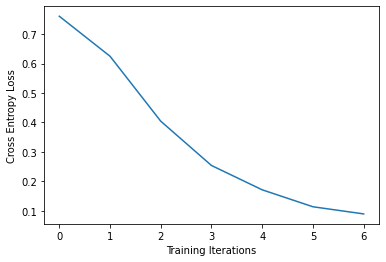

In [ ]:
# plot results of cost reduction
print('SV cost reduction')
plt.figure(3)
plt.plot(loss_list)
#plt.title('Cost Reduction for 2 qubits over {0} epochs'.format(epochs))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Perform Eval (Svec)

In [ ]:
# start eval time
start_eval = time.time()

model.eval() # set into eval mode
with no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
            
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    # batch_size goes where the 1 is here
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
           .format(sum(total_loss) / len(total_loss),
                correct / len(test_loader) / 1 * 100))
    
# end eval time
end_eval = time.time()
print('Evaluation time is: ', (end_eval - start_eval)/60, ' min')

Performance on test data:
	Loss: 0.0875
	Accuracy: 99.4%
Evaluation time is:  0.023350417613983154  min


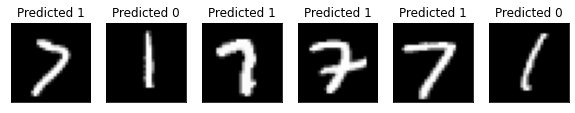

In [ ]:
# handful of examples for 2 qubit system
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        # remap class values to samp_val 1 and 2
        # where pred == 0 set it to samp_val_1, same for pred == 1
        # below lines don't work for this, need to figure out another way but not critical
        #pred.item[pred.item()==0] = samp_val_1
        #pred.item[pred.item()==1] = samp_val_2

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Pred. Samp. {}'.format(pred.item()))
        
        count += 1